In [1]:
%reset

In [2]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

In [3]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load and split data

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [5]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
idx_to_class = tuple([k for k, _ in dataset.class_to_idx.items()])
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(range(len(dataset)), [n_train_examples, n_val_examples])
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [6]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Peek data

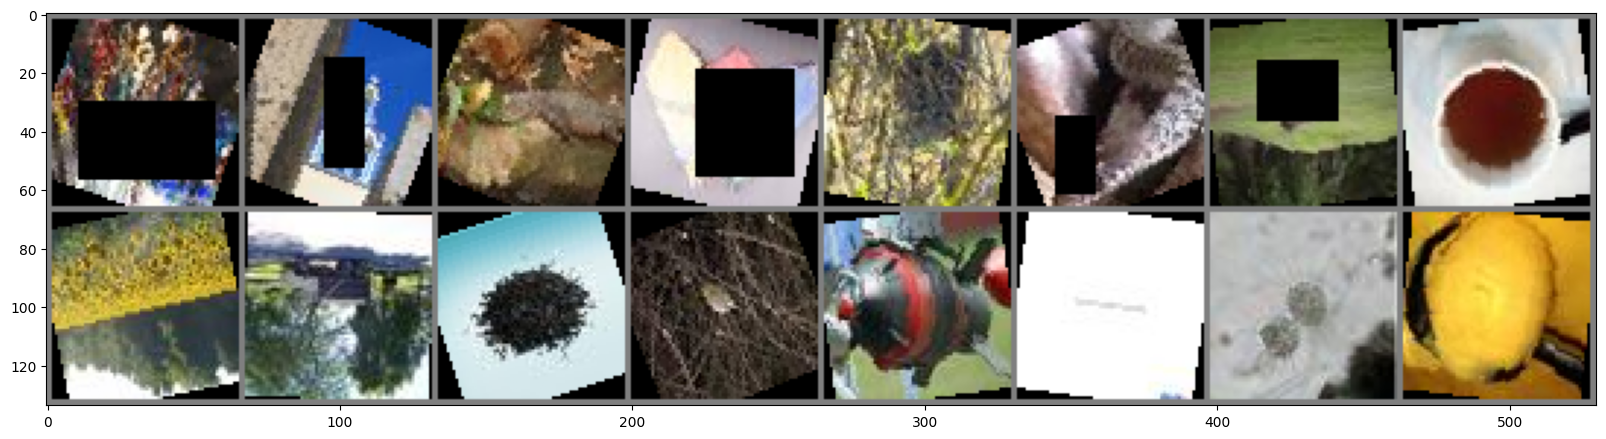

gauge acoustic crocodilian towel nest snake swine tea flower truck carbon bird bomb frog bacteria icecream


In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [9]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

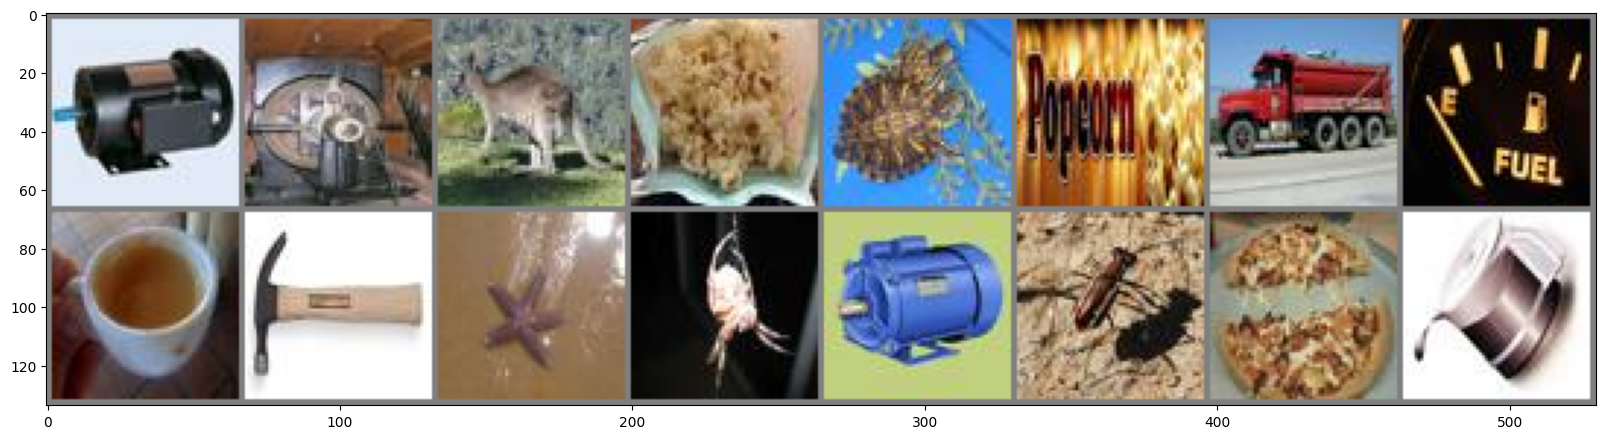

motor motor kangaroo corn turtle corn truck gauge tea hammer echinoderm spider motor beetle pizza pot


In [10]:
plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(val_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(val_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [11]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(2304, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
model = CNN(len(dataset.classes)).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 100
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    model.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )


  0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [20:54<23:34, 26.68s/it, Epoch=47, Los in train={1.7203710468131028}, Loss in eval={2.0729065359803234}]


KeyboardInterrupt: 

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_train = model(inputs)
        predicted_argmax_train = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, labels))
        predicted_train = torch.cat((predicted_train, predicted_argmax_train))

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_val = model(inputs)
        predicted_argmax_val = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, labels))
        predicted_val = torch.cat((predicted_val, predicted_argmax_val))


In [16]:
labels_train, predicted_train = labels_train.cpu() , predicted_train.cpu()
labels_val, predicted_val = labels_val.cpu() , predicted_val.cpu()

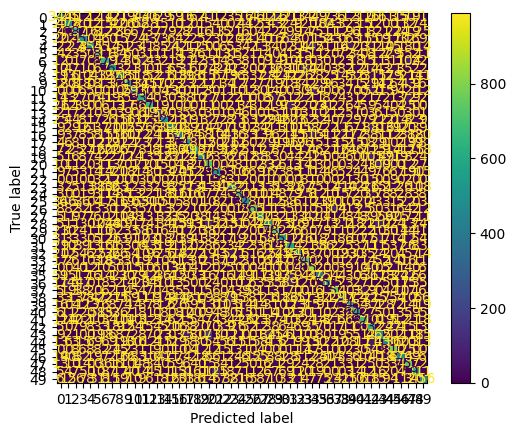

In [17]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [18]:
f1_score(labels_train, predicted_train, average='micro')

0.5336325417566186

In [19]:
mca_eval = MulticlassAccuracy(num_classes=50, average=None)

In [20]:
mca_eval(predicted_train, labels_train)

tensor([0.3153, 0.4623, 0.6333, 0.5119, 0.4260, 0.7106, 0.6094, 0.5261, 0.3333,
        0.5380, 0.4629, 0.5972, 0.6220, 0.5065, 0.4835, 0.3665, 0.3533, 0.5116,
        0.4516, 0.4183, 0.6636, 0.5306, 0.9252, 0.4276, 0.6330, 0.4907, 0.7016,
        0.4368, 0.3894, 0.7058, 0.5116, 0.5411, 0.4069, 0.6891, 0.8060, 0.3388,
        0.5279, 0.6939, 0.2700, 0.5845, 0.6134, 0.6125, 0.5761, 0.4274, 0.3909,
        0.7505, 0.4480, 0.7291, 0.5639, 0.4246])

In [21]:
f1_score(labels_val, predicted_val, average='micro')

0.4555602897315722

In [22]:
mca_eval(predicted_val, labels_val)

tensor([0.2482, 0.3773, 0.5111, 0.4028, 0.3757, 0.6320, 0.5379, 0.4394, 0.2865,
        0.4553, 0.4063, 0.4846, 0.5000, 0.3161, 0.4087, 0.3071, 0.2616, 0.4305,
        0.3147, 0.3155, 0.6219, 0.4695, 0.9070, 0.3203, 0.6006, 0.4003, 0.6875,
        0.3138, 0.3537, 0.6098, 0.4743, 0.4804, 0.2855, 0.6285, 0.7642, 0.2439,
        0.4590, 0.6152, 0.2000, 0.5036, 0.5682, 0.5745, 0.4770, 0.2893, 0.3543,
        0.6727, 0.3531, 0.6838, 0.4388, 0.2700])

In [23]:
mca_eval = MulticlassAccuracy(num_classes=50, average='macro')
mca_eval(predicted_val, labels_val)

tensor(0.4526)

Text(0, 0.5, 'Loss')

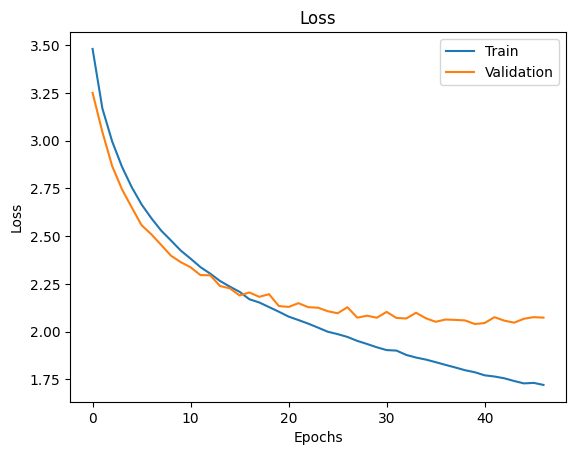

In [24]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label = "Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")